In [26]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [27]:
train_file_path = './data/train.csv'
test_file_path = './data/test.csv'
LABEL_COLUMN = 'LABEL'

In [28]:
train_dataset = tf.data.experimental.make_csv_dataset(
      train_file_path,
      batch_size=32, # Artificially small to make examples easier to show.
      label_name=LABEL_COLUMN,
      num_epochs=1
    )

In [29]:
features, labels = next(iter(train_dataset))

print(features)

OrderedDict([('x1', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([278.9886  , 241.98773 , 216.50201 , 117.87028 , 275.206   ,
       186.58134 , 306.30536 ,  54.5434  , 254.17218 , 282.8639  ,
       222.20087 , 235.87086 , 176.4775  , 190.43694 , 231.60284 ,
        97.1115  , 136.90251 ,  78.45857 , 161.6933  ,  61.912743,
       259.6211  , 122.80246 , 160.96217 , 103.05577 ,  86.18826 ,
       130.54303 ,  27.131401, 151.03671 ,  82.65123 , 323.86972 ,
       140.94939 , 179.32983 ], dtype=float32)>), ('y1', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([102.67857 , 128.69836 ,  82.92018 , 115.89126 , 102.72711 ,
       120.362755, 161.25511 , 151.08047 , 193.69783 , 208.95941 ,
       119.69156 ,  36.852314, 203.78656 , 169.19481 , 205.81638 ,
       298.89536 , 222.53163 , 148.09784 , 200.71942 , 137.81322 ,
       161.34947 , 159.93776 , 160.5328  , 313.1451  , 126.08724 ,
       143.9685  , 116.002914, 212.31995 , 103.685036, 122.95118 ,
       166.93561 , 143.57

In [30]:
def pack_features_vector(features, labels):
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

In [31]:
train_dataset = train_dataset.map(pack_features_vector)

In [32]:
features, labels = next(iter(train_dataset))

print(features[:5])



tf.Tensor(
[[202.16637  117.46752  213.52473   90.64456  228.10014   81.41236
  245.42973   74.844315 262.64667   69.35692  238.74579   98.51404
  272.9586    89.75107  293.0303    86.25186  308.9189    83.71164
  243.65793  116.430466 281.115    110.18436  305.72275  106.090805
  323.11948  102.716965 246.80884  131.35342  281.53427  132.49747
  303.15106  132.25777  319.0364   130.74756  247.51865  143.59973
  277.0706   148.46779  293.21082  150.1341   306.34042  151.29341 ]
 [210.25139  120.95043  238.50116  109.99056  266.13663  108.84389
  283.68408  111.17322  290.94794  108.21356  279.82587  144.58147
  300.28406  166.17995  311.87308  181.41933  322.49506  193.27292
  270.3851   160.51817  267.63025  176.70055  254.99255  166.80316
  250.4643   158.52422  256.27112  174.44064  253.34268  183.41858
  245.25095  171.30707  242.25064  163.24255  240.88527  185.6452
  240.70401  190.43382  233.8779   177.55417  231.33717  169.5068  ]
 [ 86.23529  141.92824  105.89809  183.09952  1

In [38]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(42,)),  # 입력의 형태가 필요합니다.
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(7)
])

In [39]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
def loss(model, x, y):
    y_ = model(x)

    return loss_object(y_true=y, y_pred=y_)

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [40]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [41]:

# 도식화를 위해 결과를 저장합니다.
train_loss_results = []
train_accuracy_results = []

num_epochs = 151

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # 훈련 루프 - 32개의 배치를 사용합니다.
    for x, y in train_dataset:
    # 모델을 최적화합니다.
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # 진행 상황을 추적합니다.
        epoch_loss_avg(loss_value)  # 현재 배치 손실을 추가합니다.
        # 예측된 레이블과 실제 레이블 비교합니다.
        epoch_accuracy(y, model(x))

  # epoch 종료
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 50 == 0:
        print("에포크 {:03d}: 손실: {:.3f}, 정확도: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

에포크 000: 손실: 38.816, 정확도: 25.226%
에포크 050: 손실: 0.370, 정확도: 89.780%
에포크 100: 손실: 0.634, 정확도: 80.983%
에포크 150: 손실: 0.532, 정확도: 83.053%


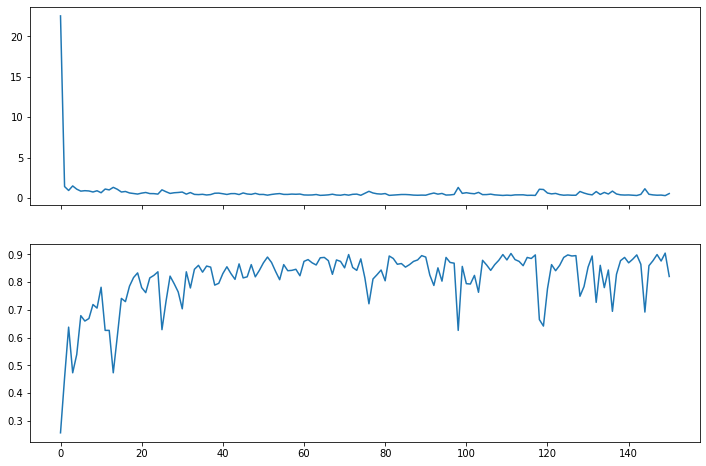

In [37]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))

axes[0].plot(train_loss_results)

axes[1].plot(train_accuracy_results)
plt.show()

In [13]:
test_dataset = tf.data.experimental.make_csv_dataset(
      test_file_path,
      batch_size=32, # Artificially small to make examples easier to show.
      label_name=LABEL_COLUMN,
      num_epochs=1,
    shuffle=False
    )

test_dataset = test_dataset.map(pack_features_vector)

In [14]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
    logits = model(x)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
    test_accuracy(prediction, y)

print("테스트 세트 정확도: {:.3%}".format(test_accuracy.result()))

테스트 세트 정확도: 91.463%


In [22]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,0.5,0.5,0.5,0.5,0.5,0.5,5.1, 3.3, 1.7, 0.5,0.5,0.5,0.5,0.5,0.5,0.5,5.1, 3.3, 1.7, 0.5,0.5,0.5,0.5,0.5,0.5,0.5,5.1, 3.3, 1.7, 0.5,0.5,0.5,0.5,0.5,0.5,0.5,3,4]
])

In [23]:
predictions = model(predict_dataset)

In [24]:
for i, logits in enumerate(predictions):
    class_idx = tf.argmax(logits).numpy()
    print(class_idx)

6


In [21]:
model.save("./model.h5")

In [25]:
model.save_weights('./checkpoints/my_checkpoint')